#  Модель для задачи классификации, которая выберет подходящий тариф

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

## Задачи проекта
### [Шаг 1. Откройте файл с данными и изучите общую информацию](#step1)

### [Шаг 2. Разделите исходные данные на обучающую, валидационную и тестовую выборки](#step2)

### [Шаг 3. Исследуйте качество разных моделей, меняя гиперпараметры](#step3)

### [Шаг 4. Проверьте качество модели на тестовой выборке.](#step4)

### [Шаг 5. Дополнительное задание](#step5)
Проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше.

# Этапы выполнения проекта

## Шаг 1. Откроем файлы с данными и изучим общую информацию. <a id='step1'></a>

In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from scikitplot.helpers import cumulative_gain_curve
from sklearn.dummy import DummyClassifier

In [7]:
df = pd.read_csv('C:/Users/Dmitry/Documents/Data/projects/mobile_tariffs_models/users_behavior.csv')


In [8]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Целевой признак - Тариф. Обычные признаки - кол-во звонков, минут, сообщение, использованных мегабайт.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.6 KB


In [10]:
df.duplicated().value_counts()

False    3214
dtype: int64

## Шаг 2. Разделим исходные данные на обучающую, валидационную и тестовую выборки <a id='step2'></a>

Разделим данные на три части в соотношении 3:1:1 (обучающая, валидационная и тестовая выборки). Проверим получившиеся данные путем сложения.

In [11]:
test = df.sample(frac=0.2,random_state=42).copy()

In [12]:
len(df)

3214

In [13]:
len(test)

643

In [14]:
train_full = df[~df.index.isin(test.index)].copy()

In [15]:
len(train_full) + len(test)

3214

In [16]:
validate = train_full.sample(frac=0.25,random_state=42).copy()
train = train_full[~train_full.index.isin(validate.index)].copy()

In [17]:
len(validate)

643

In [18]:
len(train)

1928

In [19]:
len(train_full)

2571

In [20]:
test

,calls,minutes,messages,mb_used,is_ultra
506,46.0,338.60,35.0,11428.54,0
2513,39.0,242.71,0.0,20480.11,0
354,39.0,258.02,0.0,19998.80,0
1080,36.0,230.99,19.0,23525.07,1
2389,35.0,205.35,52.0,35177.94,1
...,...,...,...,...,...
366,64.0,353.85,36.0,17413.75,0
1952,100.0,662.09,31.0,17726.01,1
29,50.0,358.01,44.0,9998.83,1
2682,0.0,0.00,23.0,21934.04,1


In [21]:
train.head(10)

,calls,minutes,messages,mb_used,is_ultra
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0
10,82.0,560.51,20.0,9619.53,1


Отделим целевые признаки от обычных.

In [22]:
features_train = train.drop(['is_ultra'], axis=1)
target_train = train['is_ultra']
test_features = test.drop(['is_ultra'], axis=1)
test_target = test['is_ultra']
features_valid = validate.drop(['is_ultra'], axis=1)
target_valid = validate['is_ultra']

## Шаг 3.  Исследуем качество разных моделей <a id='step3'></a>


Проверим качество моделей для дерева решений.

In [23]:
for depth in range (1,15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid)) 

max_depth = 1 : 0.7465007776049767
max_depth = 2 : 0.7916018662519441
max_depth = 3 : 0.7993779160186625
max_depth = 4 : 0.8009331259720062
max_depth = 5 : 0.7931570762052877
max_depth = 6 : 0.7776049766718507
max_depth = 7 : 0.7776049766718507
max_depth = 8 : 0.7931570762052877
max_depth = 9 : 0.7822706065318819
max_depth = 10 : 0.7869362363919129
max_depth = 11 : 0.776049766718507
max_depth = 12 : 0.7729393468118196
max_depth = 13 : 0.7682737169517885
max_depth = 14 : 0.7542768273716952


Наилучший показательнь при глубине дерева, равной 4.

Проверим случайный лес

In [24]:
best_model = None
best_result = 0
best_est = 0
for est in range(10, 101,10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train,target_train) 
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model.fit(features_train, target_train)
        best_result = result
        best_est = est
    print("result =", result, ": ", "est=", est )
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Количество деревьев:", best_est)

result = 0.7993779160186625 :  est= 10
result = 0.80248833592535 :  est= 20
result = 0.7962674961119751 :  est= 30
result = 0.8009331259720062 :  est= 40
result = 0.8009331259720062 :  est= 50
result = 0.8055987558320373 :  est= 60
result = 0.80248833592535 :  est= 70
result = 0.80248833592535 :  est= 80
result = 0.8040435458786936 :  est= 90
result = 0.8009331259720062 :  est= 100
Accuracy наилучшей модели на валидационной выборке: 0.8055987558320373
Количество деревьев: 60


Рассмотрим логистическую регрессию.

In [25]:
model = LogisticRegression(random_state=12345) 
model.fit(features_train,target_train) 
result = model.score(features_valid,target_valid ) 
print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7060653188180405


## Шаг 4. Проверим качество модели на тестовой выборке. <a id='step4'></a>

В качестве оптимальной модели возьмем RandomForestClassifier с количеством деревьев - 60.

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=60) 
model.fit(features_train, target_train)
test_predictions = model.predict(test_features)

In [27]:
test_target.reset_index(drop=True, inplace=True)

In [28]:
def error_count(answers, predictions):
    count = 0
    for i in range (len(answers)):
        if answers[i] != predictions[i]:
            count = count + 1    
    return count
   


In [29]:
count_errors = error_count(test_target, test_predictions)

In [30]:
print("Ошибок:", error_count(test_target, test_predictions))

Ошибок: 121


In [31]:
len(test_target)

643

In [32]:
print('Процент ошибок',count_errors/len(test_target)*100)

Процент ошибок 18.818040435458787


## Шаг 5. Дополнительное задание. <a id='step5'></a>

Создадим ручную модель. Для этого возьмем нецелевые признаки, разделим их на группы и определим средние значения, которые влияют на выбор тарифа. 

Посмотрим на значимость свойств, для создания ручной модели.

<AxesSubplot:>

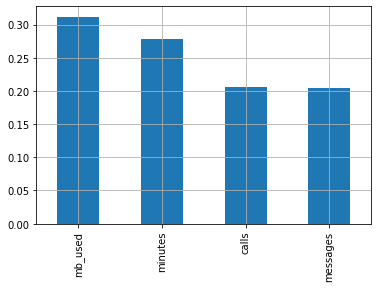

In [33]:
(pd.Series(model.feature_importances_, index=features_train.columns)
   .nlargest(4)
   .plot(kind='bar', grid=True)) 

Видно, что количество минут и мегабайт - наиболее значимые параметры для данной модели.

In [34]:
train['calls_bin'] = pd.qcut(train['calls'],5)

In [35]:
train.groupby('calls_bin')['is_ultra'].agg(['count','mean'])

,count,mean
calls_bin,,
"(-0.001, 35.0]",399,0.323308
"(35.0, 54.0]",383,0.245431
"(54.0, 70.0]",397,0.156171
"(70.0, 88.0]",364,0.236264
"(88.0, 244.0]",385,0.584416


In [36]:
tree = DecisionTreeClassifier(max_depth=1)

In [37]:
tree.fit(train[['calls']],train['is_ultra'])

DecisionTreeClassifier(max_depth=1)

[Text(167.4, 163.07999999999998, 'X[0] <= 99.5\ngini = 0.427\nsamples = 1928\nvalue = [1332, 596]'),
 Text(83.7, 54.360000000000014, 'gini = 0.377\nsamples = 1697\nvalue = [1269, 428]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.397\nsamples = 231\nvalue = [63, 168]')]

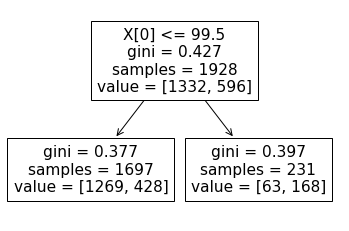

In [38]:
plot_tree(tree)

Получили среднее значение, которое определяет будущий тариф. Больше 99 звонков - пользователь с тарифом Ультра. 

In [39]:
train['calls_flag'] = (train['calls'] >= 99) * 1

In [40]:
train.groupby('calls_flag')['is_ultra'].agg(['count','mean'])

,count,mean
calls_flag,,
0,1688,0.251777
1,240,0.712500


In [41]:
train['minutes_bin'] = pd.qcut(train['minutes'],5)

[Text(167.4, 163.07999999999998, 'X[0] <= 728.425\ngini = 0.427\nsamples = 1928\nvalue = [1332, 596]'),
 Text(83.7, 54.360000000000014, 'gini = 0.38\nsamples = 1723\nvalue = [1284, 439]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.359\nsamples = 205\nvalue = [48, 157]')]

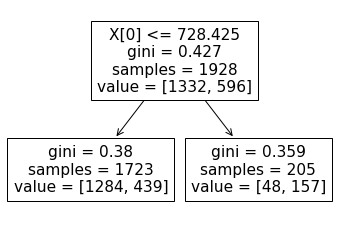

In [42]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(train[['minutes']],train['is_ultra'])
plot_tree(tree)

Получили среднее значение, которое определяет будущий тариф. Больше 728 минут - пользователь с тарифом Ультра. 

In [43]:
train['minutes_flag'] = (train['minutes'] >= 728.4) * 1

In [44]:
train.groupby('minutes_flag')['is_ultra'].agg(['count','mean'])

,count,mean
minutes_flag,,
0,1723,0.254788
1,205,0.765854


In [45]:
train['messages_bin'] = pd.qcut(train['messages'],5)

[Text(167.4, 163.07999999999998, 'X[0] <= 108.5\ngini = 0.427\nsamples = 1928\nvalue = [1332, 596]'),
 Text(83.7, 54.360000000000014, 'gini = 0.402\nsamples = 1830\nvalue = [1321, 509]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.199\nsamples = 98\nvalue = [11, 87]')]

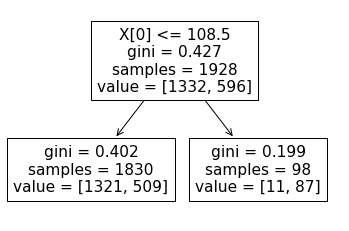

In [46]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(train[['messages']],train['is_ultra'])
plot_tree(tree)

Получили среднее значение, которое определяет будущий тариф. Больше 108 сообщений - пользователь с тарифом Ультра. 

In [47]:
train['messages_flag'] = (train['messages'] >= 108.5) * 1

In [48]:
train.groupby('messages_flag')['is_ultra'].agg(['count','mean'])

,count,mean
messages_flag,,
0,1830,0.278142
1,98,0.887755


In [49]:
train['mb_used_bin'] = pd.qcut(train['mb_used'],5)

[Text(167.4, 163.07999999999998, 'X[0] <= 26244.135\ngini = 0.427\nsamples = 1928\nvalue = [1332, 596]'),
 Text(83.7, 54.360000000000014, 'gini = 0.381\nsamples = 1720\nvalue = [1280, 440]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.375\nsamples = 208\nvalue = [52, 156]')]

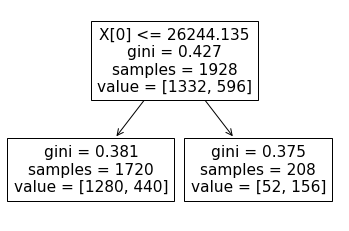

In [50]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(train[['mb_used']],train['is_ultra'])
plot_tree(tree)

Получили среднее значение, которое определяет будущий тариф. Потрачено больше 26244 Мб - пользователь с тарифом Ультра. 

In [51]:
train['mb_used_flag'] = (train['mb_used'] >= 26244.1) * 1

In [52]:
train.groupby('mb_used_flag')['is_ultra'].agg(['count','mean'])

,count,mean
mb_used_flag,,
0,1720,0.255814
1,208,0.750000


In [53]:
train['score_manual'] = train[['calls_flag','messages_flag','mb_used_flag','minutes_flag']].sum(axis=1)

In [54]:
train.groupby('score_manual')['is_ultra'].agg(['count','mean'])

,count,mean
score_manual,,
0,1484,0.188679
1,229,0.628821
2,134,0.746269
3,70,0.871429
4,11,1.000000


Получили финальные данные по ручному скорингу. 

### Рассмотрим lift по ручному скорингу. 

In [55]:
per, gain = cumulative_gain_curve(train['is_ultra'],train['score_manual'])
lc_manual_train = pd.DataFrame({'per':per,'gain':gain})
lc_manual_train['random'] = lc_manual_train['per'].copy()

<AxesSubplot:xlabel='per'>

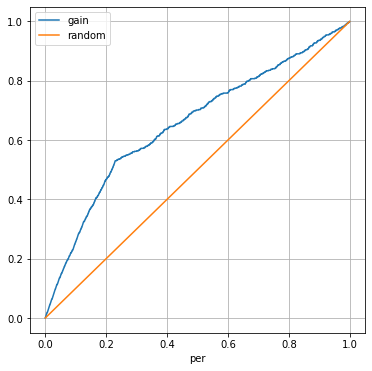

In [56]:
lc_manual_train.plot(x='per',y=['gain','random'],figsize=(6,6),grid=True)

In [57]:
auc(lc_manual_train['per'],lc_manual_train['gain'])

0.6535452463170793

Голубая линия отвечат за долю всех тарифов "Ультра" в зависимости от train['score_manual']. Например, рассмотрев топ 20% train['score_manual'], мы сможем найти почти 50% всех пользователей тарифа Ультра. Чем более выкупла линия, тем лучше классификатор. Показатель auc показывает площадь под голубой линией.

### Построим Lift по оптимальной модели

In [58]:
model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_train,target_train)

DecisionTreeClassifier(max_depth=4, random_state=12345)

In [59]:
train['score'] = model.predict_proba(features_train)[:,1]

In [60]:
model.score(features_train, target_train)

0.7946058091286307

In [61]:
per, gain = cumulative_gain_curve(train['is_ultra'],train['score'])

In [62]:
lc = pd.DataFrame({'per':per,'gain':gain})

In [63]:
lc['gain_manual']=lc_manual_train['gain']

In [64]:
lc['random'] = lc['per'].copy()

<AxesSubplot:xlabel='per'>

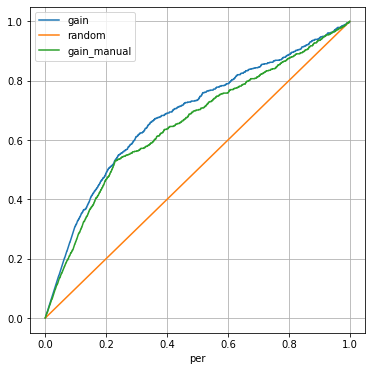

In [65]:
lc.plot(x='per',y=['gain','random','gain_manual'],figsize=(6,6),grid=True)

Рассчитаем площадь под lift кривой

In [66]:
auc(lc['per'],lc['gain'])

0.6833706382800968

Показатель auc немного выше, чем для ручной модели. 

### Проверим адекватнось модели с помощью DummyClassifier

In [67]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)




DummyClassifier(strategy='most_frequent')

In [68]:
dummy_clf.score(features_train, target_train)

0.6908713692946058

Показатель по модели с деревом решений выше, чем данным классификатором. 